In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import string
import datetime

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
df = pd.read_csv('../data/math_geneology_final.csv')
#df = df.head(500)
df = df.fillna(' ')

# Clean Data

In [4]:
#### Ensure Certain Columns Exist
cols = ['advisor_year','student_year','advisor_school','student_school']
for col in cols:
    df = df.loc[df[col].notnull() & (df[col] != ' '),:]

#### School Names

In [5]:
for col in ['student_school','advisor_school']:
    df[col] = [x.strip() for x in df[col]]

#### Years

In [6]:
def fix_year(char, col):
    
    # Some people have 2 years in the year column
    # Years are usually split by "," or "/" or " " or "-". Keep only the first year
    rows_to_fix = [len(str(x)) > 4 for x in df[col]]
    df.loc[rows_to_fix,col] = [x.split(char)[0].strip() for x in df.loc[rows_to_fix,col]]
    
for char in [',','/',' ','-']:
    fix_year(char,'advisor_year')
    fix_year(char,'student_year')    

In [7]:
# Convert to Integer
df = df.loc[(df.student_year != 'Aug.'),:]
df.advisor_year = [int(x) for x in df.advisor_year]
df.student_year = [int(x) for x in df.student_year]
df = df.query('student_year < 2020 & student_year > 1000')

# Graph

In [8]:
def make_school_digraph(df_year):
    schools_df = pd.concat([df_year[[c]].rename(columns = {c: "school"}) for c in ["student_school", "advisor_school"]]).drop_duplicates()
    
    school_digraph = nx.DiGraph()
    # Nodes are schools (student and advisors) identified by name
    school_digraph.add_nodes_from(schools_df.school.values)
    
    # Edges connect advisor and student schools and are weighted by the number of advisor-students
    edges_df = df_year.groupby(["student_school", "advisor_school"], as_index = False).agg({"student_id": "count"})
    edges = [(e["advisor_school"], e["student_school"], {"weight": e["student_id"]}) for e in edges_df.to_dict(orient = "records")]
    school_digraph.add_edges_from(edges)
    return school_digraph

In [9]:
df_filtered = df.query('student_year == 2010')
school_digraph = make_school_digraph(df_filtered)

# Analysis

Preliminary Notes:
- A path is a sequence of nodes with property that each consecutive pair in the sequence is connected by an edge. In this context, a path [A -> B -> C] would mean that at least one student graduated from school A then subsequently taught students at school B AND at least one student graduated from school B then subsequently taught students at school C.

#### Centrality:

**Degree**: The degree centrality for a node v is the fraction of nodes it is connected to.

- A school with high degree centrality receives/sends professors to/from a wide variety of schools

**Eigenvector**: Eigenvector centrality computes the centrality for a node based on the centrality of its neighbors. (using adjacency matrix)

- A school with high eigenvector centrality receives/sends professors to/from schools that are also highly ranked

**Closeness**: Reciprocal of the average shortest path distance incoming to the node over all reachable nodes (use G.reverse() to use outward distance)

**Betwenness**: Sum of the fraction of all-pairs shortest paths that pass through the node

In [11]:
def get_centrality_measures(G):

    centrality_measures = [
        ['degree', nx.degree_centrality(G)],
        ['in_degree', nx.in_degree_centrality(G)],
        ['out_degree', nx.out_degree_centrality(G)],
        ['in_eigenvector', nx.eigenvector_centrality(G, weight='weight')],
        ['out_eigenvector', nx.eigenvector_centrality(G.reverse(), weight='weight')],    
        ['in_closeness', nx.closeness_centrality(G)],
        ['out_closeness', nx.closeness_centrality(G.reverse())],
        ['betweenness',nx.betweenness_centrality(G, weight='weight')]
    ]
    
    top_tens = [pd.Series(measure[1]).sort_values(ascending=False) for measure in centrality_measures]
    df_centrality = pd.concat(top_tens,axis=1,sort=False)
    df_centrality.columns = [measure[0] for measure in centrality_measures]
    df_centrality['school'] = df_centrality.index
    
    return(df_centrality)

In [12]:
school_centralities = get_centrality_measures(school_digraph)
school_centralities.corr()

,degree,in_degree,out_degree,in_eigenvector,out_eigenvector,in_closeness,out_closeness,betweenness
degree,1.000000,0.868673,0.962935,0.687088,0.581557,0.396512,0.619136,0.914031
in_degree,0.868673,1.000000,0.702853,0.541186,0.315091,0.555753,0.561576,0.791131
out_degree,0.962935,0.702853,1.000000,0.691931,0.663504,0.266757,0.583256,0.881711
in_eigenvector,0.687088,0.541186,0.691931,1.000000,0.838643,0.231371,0.307197,0.620061
out_eigenvector,0.581557,0.315091,0.663504,0.838643,1.000000,0.113323,0.220704,0.509412
in_closeness,0.396512,0.555753,0.266757,0.231371,0.113323,1.000000,0.239883,0.350615
out_closeness,0.619136,0.561576,0.583256,0.307197,0.220704,0.239883,1.000000,0.576677
betweenness,0.914031,0.791131,0.881711,0.620061,0.509412,0.350615,0.576677,1.000000


In [14]:
pd.set_option('display.max_rows', None)

In [15]:
school_centralities.sort_values('out_eigenvector',ascending=False).head(100)

,degree,in_degree,out_degree,in_eigenvector,out_eigenvector,in_closeness,out_closeness,betweenness,school
Massachusetts Institute of Technology,0.110919,0.021664,0.089255,7.614882e-01,0.779624,0.132437,0.309186,0.022681,Massachusetts Institute of Technology
Harvard University,0.071924,0.012998,0.058925,1.007948e-01,0.395960,0.124368,0.288158,0.011005,Harvard University
"University of California, Berkeley",0.120451,0.025997,0.094454,2.896043e-01,0.269237,0.134781,0.307023,0.023870,"University of California, Berkeley"
Stanford University,0.092721,0.019931,0.072790,1.103767e-01,0.242845,0.130688,0.298810,0.016434,Stanford University
The University of Chicago,0.055459,0.011265,0.044194,5.230079e-02,0.159320,0.121319,0.282982,0.009567,The University of Chicago
Princeton University,0.074523,0.019931,0.054593,1.206361e-01,0.155355,0.126837,0.292132,0.013464,Princeton University
California Institute of Technology,0.056326,0.013865,0.042461,6.814898e-02,0.100006,0.124524,0.276238,0.009897,California Institute of Technology
University of Cambridge,0.059792,0.012132,0.047660,1.504827e-02,0.079245,0.120287,0.279888,0.013975,University of Cambridge
Columbia University,0.057192,0.019064,0.038128,1.010439e-01,0.072333,0.131820,0.270760,0.017636,Columbia University
Cornell University,0.067591,0.015598,0.051993,7.859702e-02,0.072050,0.124056,0.272199,0.013820,Cornell University


# Centralities Over Time

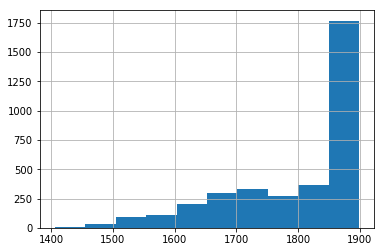

In [16]:
df['student_year'][df['student_year']<1900].hist()

In [17]:
school_digraph_list = []
centralities_over_time_list = []
years = range(1800,2018,10)

for year in years:
    print(year)
    df_students_year = df.query('student_year >= @year & student_year < @year + 10')
    school_digraph = make_school_digraph(df_students_year)
    df_centralities_year = get_centrality_measures(school_digraph)
    df_centralities_year['year'] = year
    
    school_digraph_list.append(school_digraph)
    centralities_over_time_list.append(df_centralities_year)

1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010


In [18]:
df_centralities = pd.concat(centralities_over_time_list,axis=0,sort=False)

# Lineplots

In [19]:
df_centralities['year'].value_counts()

2010    2543
2000    1919
1990    1317
1980    1026
1970     814
1960     593
1950     359
1940     241
1930     204
1920     151
1910     124
1900     117
1890      88
1880      72
1870      69
1860      50
1840      47
1820      41
1850      36
1830      33
1810      30
1800      28
Name: year, dtype: int64

In [20]:
from bokeh.io import show
from bokeh.models import ColumnDataSource
from bokeh.models import HoverTool
from bokeh.palettes import cividis
from bokeh.plotting import figure

In [21]:
df_centralities.head()

,degree,in_degree,out_degree,in_eigenvector,out_eigenvector,in_closeness,out_closeness,betweenness,school,year
Georg-August-Universität Göttingen,0.222222,0.148148,0.074074,7.071198e-01,4.374816e-01,0.132275,0.037037,0.007123,Georg-August-Universität Göttingen,1800
Universiteit Utrecht,0.185185,0.148148,0.037037,1.998581e-11,1.989436e-13,0.111111,0.000000,0.000000,Universiteit Utrecht,1800
Ludwig-Maximilians-Universität Landshut,0.148148,0.111111,0.037037,4.791107e-06,2.199785e-06,0.074074,0.000000,0.000000,Ludwig-Maximilians-Universität Landshut,1800
Universität Helmstedt,0.148148,0.074074,0.074074,5.429921e-05,4.374783e-01,0.055556,0.049383,0.005698,Universität Helmstedt,1800
Friedrich-Schiller-Universität Jena,0.148148,0.074074,0.074074,4.192218e-06,4.374360e-01,0.049383,0.055556,0.005698,Friedrich-Schiller-Universität Jena,1800


In [22]:
# Subset to Schools that are in top N-number of schools in at least one decade

def line_plot_schools(df_centralities, centrality_measure, n):

    schools_to_keep = []
    for year in df_centralities['year'].unique():
        schools = df_centralities.loc[df_centralities['year'] == year,:].sort_values(centrality_measure, ascending = False)['school'][0:n]
        schools_to_keep += list(schools)
    df_centralities_subset = df_centralities.loc[[x in list(set(schools_to_keep)) for x in df_centralities['school']],:]   
    
    
    # Plot (Copied and pasted from some blog -- hence the messiness)
    
    df = df_centralities_subset
    df = df.rename({'year':'x',centrality_measure:'y','school':'group'},axis=1)

    grp_list = df.group.unique()
    xs = [df.loc[df.group == i].x for i in grp_list]
    ys = [df.loc[df.group == i].y for i in grp_list]
    source = ColumnDataSource(data=dict(
         x = xs,
         y = ys,
         color = cividis(len(grp_list)),
         group = grp_list))
    p3 = figure(plot_width=1600, plot_height=900)
    p3.multi_line(
         xs='x',
         ys='y',
         legend=False,
         source=source,
         line_color='color')
    #Add hover tools, basically an invisible line
    source2 = ColumnDataSource(dict(
         invisible_xs=df.x,
         invisible_ys=df.y,
         group = df.group))
    line = p3.line(
         'invisible_xs',
         'invisible_ys',
         source=source2,
         alpha=0)
    #hover = HoverTool(tooltips =[
    #     ('group','@group')])
    #hover.renderers = [line]
    #p3.add_tools(hover)
    p3.add_tools(HoverTool(show_arrow=False, line_policy='nearest', tooltips=[
        ('group', '@group')
    ]))

    show(p3)

In [23]:
line_plot_schools(df_centralities, 'degree',50)

In [24]:
line_plot_schools(df_centralities, 'in_degree',50)

In [ ]:
line_plot_schools(df_centralities, 'out_degree',50)

In [ ]:
line_plot_schools(df_centralities, 'in_eigenvector',50)

In [25]:
line_plot_schools(df_centralities, 'out_eigenvector',50)

In [ ]:
line_plot_schools(df_centralities, 'in_closeness',50)

In [ ]:
line_plot_schools(df_centralities, 'out_closeness',50)

In [ ]:
line_plot_schools(df_centralities, 'betweenness',50)

# Network Plots

In [26]:
def draw_graph_layout(graph, layout, ax):
    ax.scatter([v[0] for k, v in layout.items()], [v[1] for k, v in layout.items()], s = 2)
    for e in [e for e in graph.edges]:
        ax.plot([layout[i][0] for i in e], [layout[i][1] for i in e], c = "steelblue", lw = 0.1)

In [27]:
a = nx.kamada_kawai_layout(school_digraph)

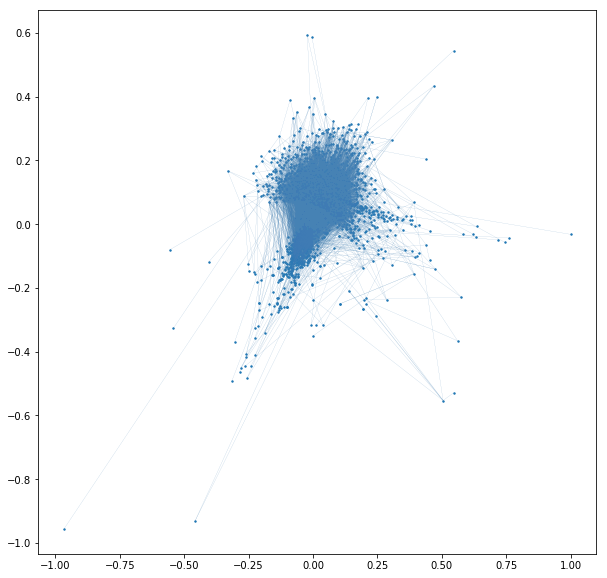

In [28]:
fig, ax = plt.subplots(figsize = (10, 10))
draw_graph_layout(school_digraph, a, ax)
